# Aggregation of Results and Generation of Tables and Figures

This notebook aggregates model predictions and evaluation outputs to generate
the final tables and figures reported in the paper
"Large Language Models for Automated ICD-10 Coding of Obstetric Clinical Notes in Portuguese".

The analyses include:
- Summary performance metrics across models
- Bootstrap-based 95% confidence intervals
- Comparative results for Portuguese and English-translated notes
- Figures illustrating code diversity, performance distributions, and uncertainty

All inputs to this notebook are derived from intermediate outputs generated
by the inference and bootstrap notebooks. No clinical data are distributed
with this repository.

In [ ]:
import re
import ast
import math
import numpy as np
import pandas as pd

# ==== CONFIG ====
DF = df
TEXT_COL = "25. Evolução Alta"
GOLD_COL = "21. CID de Alta"

MODEL_COLS = [
    "API GPT‑4o",
    "API GPT-Mini",
    "API modelo Tunado",
    "API Maritalk",
    "API Deep-Seek",
    "API Gemini",
]

# ==== Helpers: normalização e parsing robusto ====
CODE_REGEX = re.compile(r'^[A-TV-Z]\d{2}(?:\.\d+)?$')  # ICD-10 (ignora U*)
def normalize_code(raw: str) -> str | None:
    if not isinstance(raw, str):
        raw = str(raw)
    c = raw.strip().upper()
    # separadores e espaços
    c = c.replace(',', '.')
    c = re.sub(r'\s+', '', c)
    # 0-leading -> O (ex.: "047" -> "O47", "0 80.1" -> "O80.1")
    if len(c) >= 3 and c[0] == '0' and c[1:3].isdigit():
        c = 'O' + c[1:]
    # cortar trailing pontuação estranha
    c = c.rstrip('.,;:')
    return c if CODE_REGEX.match(c) else None

def parse_any(val) -> list[str]:
    """Aceita list, string tipo '[O42, O80.1]' ou 'O42; O80.1, O24.9' etc."""
    if val is None or (isinstance(val, float) and math.isnan(val)):
        return []
    # se já é lista, normaliza cada item
    if isinstance(val, (list, tuple, set)):
        cand = list(val)
    else:
        s = str(val).strip()
        # tenta interpretar como lista Python
        if s.startswith('[') and s.endswith(']'):
            try:
                parsed = ast.literal_eval(s)
                cand = parsed if isinstance(parsed, (list, tuple, set)) else [s]
            except Exception:
                cand = [s]
        else:
            # normaliza separadores para ponto-e-vírgula e divide
            s = s.replace('\n', ' ').replace('|', ';').replace('/', ';')
            s = s.replace('\t', ' ').replace('  ', ' ')
            # substitui vírgula por ponto APENAS em padrões dígito vírgula dígito (e.g., O24,9)
            s = re.sub(r'(?<=\d),(?=\d)', '.', s)
            # agora separa por ; , ou espaço
            cand = re.split(r'[;,]', s)
    # normaliza e valida
    valid = []
    for x in cand:
        if x is None:
            continue
        code = normalize_code(str(x))
        if code:
            valid.append(code)
    # dedup dentro da nota
    return sorted(set(valid))

def three_char(code: str) -> str:
    return code[:3]

# ==== Pré-processa todas as colunas de modelo para listas normalizadas ====
dfp = DF.copy()
for col in MODEL_COLS:
    dfp[col + "__parsed"] = dfp[col].apply(parse_any)

# ==== Tabela S2.1: resumo por modelo ====
rows = []
for col in MODEL_COLS:
    parsed_col = col + "__parsed"
    n_notes = len(dfp)
    preds_per_note = dfp[parsed_col].apply(len)
    notes_with_any = (preds_per_note > 0).sum()
    pct_with_any = 100 * notes_with_any / n_notes if n_notes else 0.0
    mean = preds_per_note.mean()
    sd = preds_per_note.std(ddof=1)
    med = preds_per_note.median()
    q1 = preds_per_note.quantile(0.25)
    q3 = preds_per_note.quantile(0.75)

    # vocabulário distinto (dedup por nota)
    all_leaf = set().union(*dfp[parsed_col].tolist())
    all_3ch = set(three_char(c) for c in all_leaf)

    # cobertura top-10/20 por categoria 3ch (contando uma vez por ocorrência por nota)
    # primeiro, expande categorias por nota
    cats_long = dfp[parsed_col].apply(lambda xs: sorted(set(three_char(c) for c in xs)))
    cats_counts = {}
    total_cats = 0
    for xs in cats_long:
        for c in xs:
            cats_counts[c] = cats_counts.get(c, 0) + 1
            total_cats += 1
    top10 = sum(x for _, x in sorted(cats_counts.items(), key=lambda kv: kv[1], reverse=True)[:10])
    top20 = sum(x for _, x in sorted(cats_counts.items(), key=lambda kv: kv[1], reverse=True)[:20])
    cov10 = 100 * top10 / total_cats if total_cats else 0.0
    cov20 = 100 * top20 / total_cats if total_cats else 0.0

    rows.append({
        "Model": col,
        "Notes (n)": n_notes,
        "Notes with ≥1 prediction (%)": f"{pct_with_any:.2f}%",
        "Predictions per note — mean ± SD": f"{mean:.2f} ± {sd:.2f}",
        "Predictions per note — median [IQR]": f"{int(med)} [{int(q1)}–{int(q3)}]",
        "Distinct leaf codes": len(all_leaf),
        "Distinct 3-char categories": len(all_3ch),
        "Top-10 category coverage": f"{cov10:.2f}%",
        "Top-20 category coverage": f"{cov20:.2f}%"
    })

tbl_S2_1 = pd.DataFrame(rows)

# ==== Tabela S2.2: Top-20 categorias (3 chars) por modelo ====
long_rows = []
for col in MODEL_COLS:
    parsed_col = col + "__parsed"
    cats_long = dfp[parsed_col].apply(lambda xs: sorted(set(three_char(c) for c in xs)))
    counts = {}
    total = 0
    for xs in cats_long:
        for c in xs:
            counts[c] = counts.get(c, 0) + 1
            total += 1
    top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:20]
    for cat, f in top:
        long_rows.append({
            "Model": col,
            "Category_3ch": cat,
            "Frequency": f,
            "% of all predicted categories": round(100 * f / total, 2) if total else 0.0
        })
tbl_S2_2 = pd.DataFrame(long_rows)

# ==== Tabela S2.3: Top-20 leaf codes por modelo ====
leaf_rows = []
for col in MODEL_COLS:
    parsed_col = col + "__parsed"
    counts = {}
    total = 0
    for xs in dfp[parsed_col]:
        for c in sorted(set(xs)):  # dedup intra-nota
            counts[c] = counts.get(c, 0) + 1
            total += 1
    top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:20]
    for code, f in top:
        leaf_rows.append({
            "Model": col,
            "Leaf code": code,
            "Frequency": f,
            "% of all predicted leaf codes": round(100 * f / total, 2) if total else 0.0
        })
tbl_S2_3 = pd.DataFrame(leaf_rows)

# ==== (Opcional) Tabela S2.4: Jaccard entre vocabulários de leaf codes ====
def vocab(df, col_parsed):
    return set().union(*df[col_parsed].tolist())

jac_rows = []
for i, coli in enumerate(MODEL_COLS):
    Vi = vocab(dfp, coli + "__parsed")
    for j, colj in enumerate(MODEL_COLS):
        Vj = vocab(dfp, colj + "__parsed")
        inter = len(Vi & Vj)
        union = len(Vi | Vj) if (Vi or Vj) else 1
        jacc = inter / union
        jac_rows.append({"Model_i": coli, "Model_j": colj, "Jaccard (leaf vocab)": round(jacc, 4)})
tbl_S2_4 = pd.DataFrame(jac_rows)

# ==== Export TSV p/ colar no Docs ====
print("=== Table S2.1 (TSV) ===")
print(tbl_S2_1.to_csv(sep="\t", index=False))

print("\n=== Table S2.2 (TSV) ===")
print(tbl_S2_2.to_csv(sep="\t", index=False))

print("\n=== Table S2.3 (TSV) ===")
print(tbl_S2_3.to_csv(sep="\t", index=False))

print("\n=== Table S2.4 (TSV, optional) ===")
print(tbl_S2_4.pivot(index="Model_i", columns="Model_j", values="Jaccard (leaf vocab)").to_csv(sep="\t"))

=== Table S2.1 (TSV) ===
Model	Notes (n)	Notes with ≥1 prediction (%)	Predictions per note — mean ± SD	Predictions per note — median [IQR]	Distinct leaf codes	Distinct 3-char categories	Top-10 category coverage	Top-20 category coverage
API GPT‑4o	1117	99.73%	4.42 ± 1.36	4 [3–5]	622	352	40.23%	61.34%
API GPT-Mini	1117	99.73%	5.26 ± 0.99	5 [5–6]	488	298	56.85%	73.72%
API modelo Tunado	1117	99.82%	5.68 ± 2.06	5 [5–6]	523	241	55.43%	75.54%
API Maritalk	1117	99.02%	6.24 ± 1.89	6 [5–7]	977	481	40.74%	55.34%
API Deep-Seek	1117	99.82%	5.53 ± 1.35	5 [5–6]	622	349	46.22%	66.14%
API Gemini	1117	99.91%	4.93 ± 1.34	5 [4–6]	629	371	45.70%	67.70%


=== Table S2.2 (TSV) ===
Model	Category_3ch	Frequency	% of all predicted categories
API GPT‑4o	O24	280	5.77
API GPT‑4o	Z39	246	5.07
API GPT‑4o	Z30	223	4.6
API GPT‑4o	Z37	192	3.96
API GPT‑4o	O99	187	3.86
API GPT‑4o	O60	186	3.84
API GPT‑4o	O14	165	3.4
API GPT‑4o	O70	161	3.32
API GPT‑4o	O36	159	3.28
API GPT‑4o	O82	152	3.13
API GPT‑4o	O13	143	2.95
API GPT‑4o	O

In [ ]:
df = df[['25. Evolução Alta', '21. CID de Alta']].copy()


In [ ]:
df

In [ ]:
import re, numpy as np, pandas as pd

COL_TEXTO = '25. Evolução Alta'
COL_CIDS  = '21. CID de Alta'

def normalize_token(t):
    s = re.sub(r"\s+","", str(t)).upper()
    # vírgula decimal -> ponto (ex.: O24,4)
    if ',' in s and re.match(r'^[A-Z]\d{2},\d+$', s):
        s = s.replace(',', '.')
    # hífen -> ponto
    if '-' in s:
        s = s.replace('-', '.')
    s = re.sub(r'^0(?=\d{2}(?:\.\d+)?)', 'O', s)
    return s if re.match(r'^[A-Z]\d{2}(\.\d+)?$', s) else None

def to_code_list(x):
    if isinstance(x, (list, np.ndarray)):
        items = list(x)
    else:
        s = "" if pd.isna(x) else str(x)
        s = s.replace('/', ';')
        items = [t.strip() for t in s.split(';') if t.strip()]
    out=[]
    for t in items:
        z = normalize_token(t)
        if z: out.append(z)
    return sorted(set(out))

# Recalcula do zero
df_all = df[[COL_TEXTO, COL_CIDS]].copy()
df_all.columns = ['texto','codigos']
df_all['codes_list']  = df_all['codigos'].apply(to_code_list)
df_all['codes_3char'] = df_all['codes_list'].apply(lambda lst: sorted({c.split('.')[0] for c in lst}))
df_all['has_codes']   = df_all['codes_list'].str.len().gt(0)

# Mantém todas com ≥1 CID válido (inclui a sem texto)
df_all = df_all[df_all['has_codes']].copy()
print("n (com ≥1 CID válido):", df_all.shape[0])




n (com ≥1 CID válido): 1117


In [ ]:
# === S1 e Top-20 direto de df_all (n=1117) ===
import numpy as np, pandas as pd, re

# 1) garantir colunas necessárias em df_all
assert {'texto','codes_list','codes_3char'}.issubset(df_all.columns)

# 2) tokens (0 para texto vazio)
def count_tokens(s):
    s = "" if s is None else str(s)
    return len(re.findall(r"\w+", s, flags=re.UNICODE))

df_all['n_tokens'] = df_all['texto'].apply(count_tokens)

# 3) códigos por nota
df_all['n_codes_leaf'] = df_all['codes_list'].str.len()
df_all['n_codes_3ch']  = df_all['codes_3char'].str.len()

# 4) agregados
all_leaf = [c for lst in df_all['codes_list'] for c in lst]
all_3ch  = [c for lst in df_all['codes_3char'] for c in lst]
distinct_leaf = sorted(set(all_leaf))
distinct_3ch  = sorted(set(all_3ch))

freq_3ch = pd.Series(all_3ch).value_counts()
total_labels_3ch = int(freq_3ch.sum())

def summarize_series(s: pd.Series):
    s = pd.to_numeric(s, errors='coerce').dropna()
    if s.empty:
        return dict(mean=np.nan,std=np.nan,median=np.nan,q1=np.nan,q3=np.nan,iqr=np.nan)
    q1, q3 = np.percentile(s, [25, 75])
    return dict(
        mean=float(np.mean(s)),
        std=float(np.std(s, ddof=1)) if len(s)>1 else 0.0,
        median=float(np.median(s)),
        q1=float(q1), q3=float(q3), iqr=float(q3-q1)
    )

tok  = summarize_series(df_all['n_tokens'])
leaf = summarize_series(df_all['n_codes_leaf'])
ch3  = summarize_series(df_all['n_codes_3ch'])

cov_top10 = (freq_3ch.head(10).sum()/total_labels_3ch) if total_labels_3ch else 0.0
cov_top20 = (freq_3ch.head(20).sum()/total_labels_3ch) if total_labels_3ch else 0.0
pct_lt5   = (freq_3ch[freq_3ch<5].shape[0]/freq_3ch.shape[0]*100) if freq_3ch.shape[0] else 0.0
pct_lt10  = (freq_3ch[freq_3ch<10].shape[0]/freq_3ch.shape[0]*100) if freq_3ch.shape[0] else 0.0

# 5) montar S1
S1 = pd.DataFrame([
    ("Notas (n)", df_all.shape[0]),
    ("Tokens por nota — média ± DP", f"{tok['mean']:.1f} ± {tok['std']:.1f}"),
    ("Tokens por nota — mediana [IQR]", f"{tok['median']:.0f} [{tok['q1']:.0f}–{tok['q3']:.0f}]"),
    ("Códigos por nota (leaf) — média ± DP", f"{leaf['mean']:.2f} ± {leaf['std']:.2f}"),
    ("Códigos por nota (leaf) — mediana [IQR]", f"{leaf['median']:.0f} [{leaf['q1']:.0f}–{leaf['q3']:.0f}]"),
    ("Códigos por nota (3 chars) — média ± DP", f"{ch3['mean']:.2f} ± {ch3['std']:.2f}"),
    ("Códigos por nota (3 chars) — mediana [IQR]", f"{ch3['median']:.0f} [{ch3['q1']:.0f}–{ch3['q3']:.0f}]"),
    ("Categorias 3 chars distintas", len(distinct_3ch)),
    ("Códigos leaf distintos", len(distinct_leaf)),
    ("Cobertura top-10 categorias (3 chars)", f"{cov_top10*100:.2f}%"),
    ("Cobertura top-20 categorias (3 chars)", f"{cov_top20*100:.2f}%"),
    ("% de categorias (3 chars) com suporte <5",  f"{pct_lt5:.2f}%"),
    ("% de categorias (3 chars) com suporte <10", f"{pct_lt10:.2f}%"),
], columns=["Métrica","Valor"])

print("=== Tabela S1 (resumo do corpus) ===")
print(S1)

# 6) Top-20 categorias (3 chars)
top20 = (freq_3ch.head(20)
         .rename_axis("Categoria_3ch")
         .reset_index(name="Frequência"))
top20["% do total"] = (top20["Frequência"]/total_labels_3ch*100).round(2)

print("\n=== Top-20 categorias (3 chars) ===")
print(top20)

# 7) Salvar CSV e LaTeX
S1.to_csv("/content/Tabela_S1_resumo_corpus.csv", index=False)
top20.to_csv("/content/Top20_categorias_3chars.csv", index=False)

with open("/content/Tabela_S1_resumo_corpus.tex","w",encoding="utf-8") as f:
    f.write(S1.to_latex(index=False, escape=False))
with open("/content/Top20_categorias_3chars.tex","w",encoding="utf-8") as f:
    f.write(top20.to_latex(index=False, escape=False))

print("\nArquivos salvos:")
print(" - /content/Tabela_S1_resumo_corpus.csv  |  .tex")
print(" - /content/Top20_categorias_3chars.csv  |  .tex")



=== Tabela S1 (resumo do corpus) ===
                                       Métrica          Valor
0                                    Notas (n)           1117
1                 Tokens por nota — média ± DP  251.1 ± 124.8
2              Tokens por nota — mediana [IQR]  222 [178–292]
3         Códigos por nota (leaf) — média ± DP    2.58 ± 1.39
4      Códigos por nota (leaf) — mediana [IQR]        2 [2–3]
5      Códigos por nota (3 chars) — média ± DP    2.58 ± 1.38
6   Códigos por nota (3 chars) — mediana [IQR]        2 [2–3]
7                 Categorias 3 chars distintas            261
8                       Códigos leaf distintos            450
9        Cobertura top-10 categorias (3 chars)         58.30%
10       Cobertura top-20 categorias (3 chars)         73.09%
11    % de categorias (3 chars) com suporte <5         74.33%
12   % de categorias (3 chars) com suporte <10         86.97%

=== Top-20 categorias (3 chars) ===
   Categoria_3ch  Frequência  % do total
0            O82 

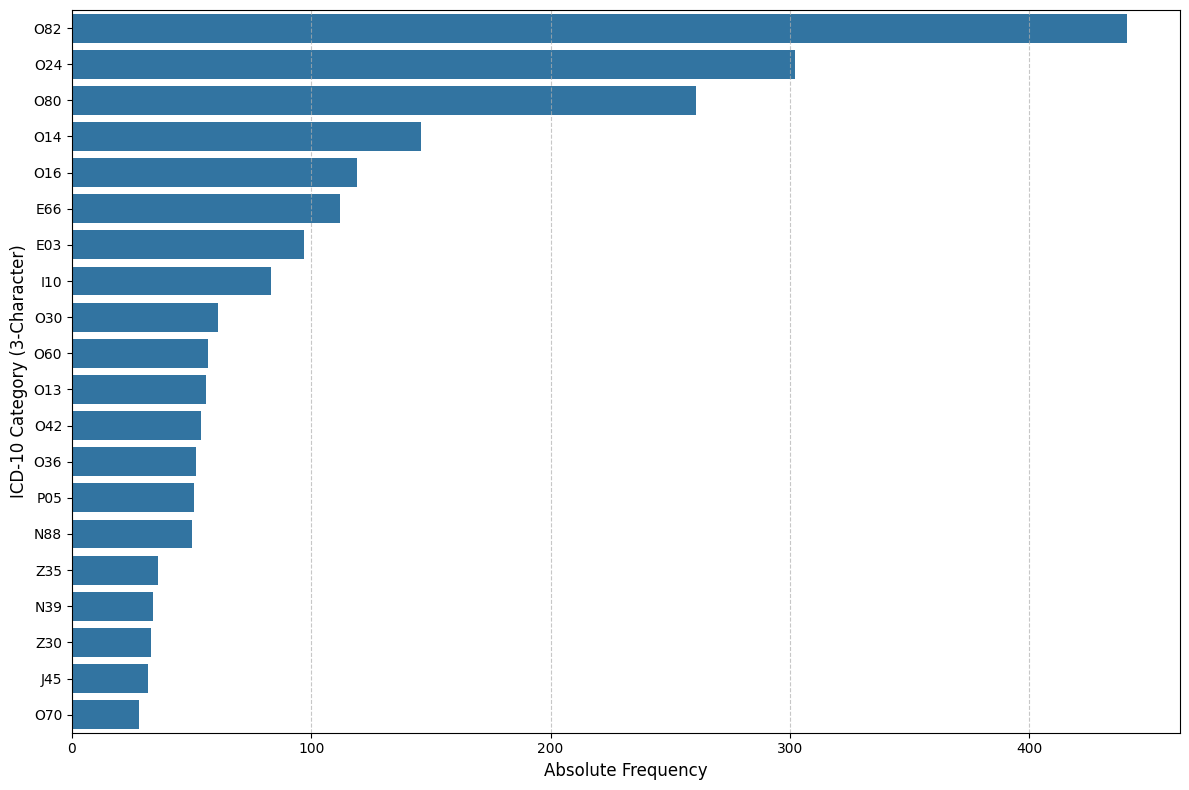

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Bloco de Visualização em Inglês ---
plt.figure(figsize=(12, 8))

# Gráfico com um único tom de azul
sns.barplot(
    data=top20,
    y="Categoria_3ch",
    x="Frequência",
    color='#1f77b4',  # Azul consistente
    dodge=False
)

# Título e eixos em inglês
plt.title("", fontsize=16)
plt.xlabel("Absolute Frequency", fontsize=12)
plt.ylabel("ICD-10 Category (3-Character)", fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

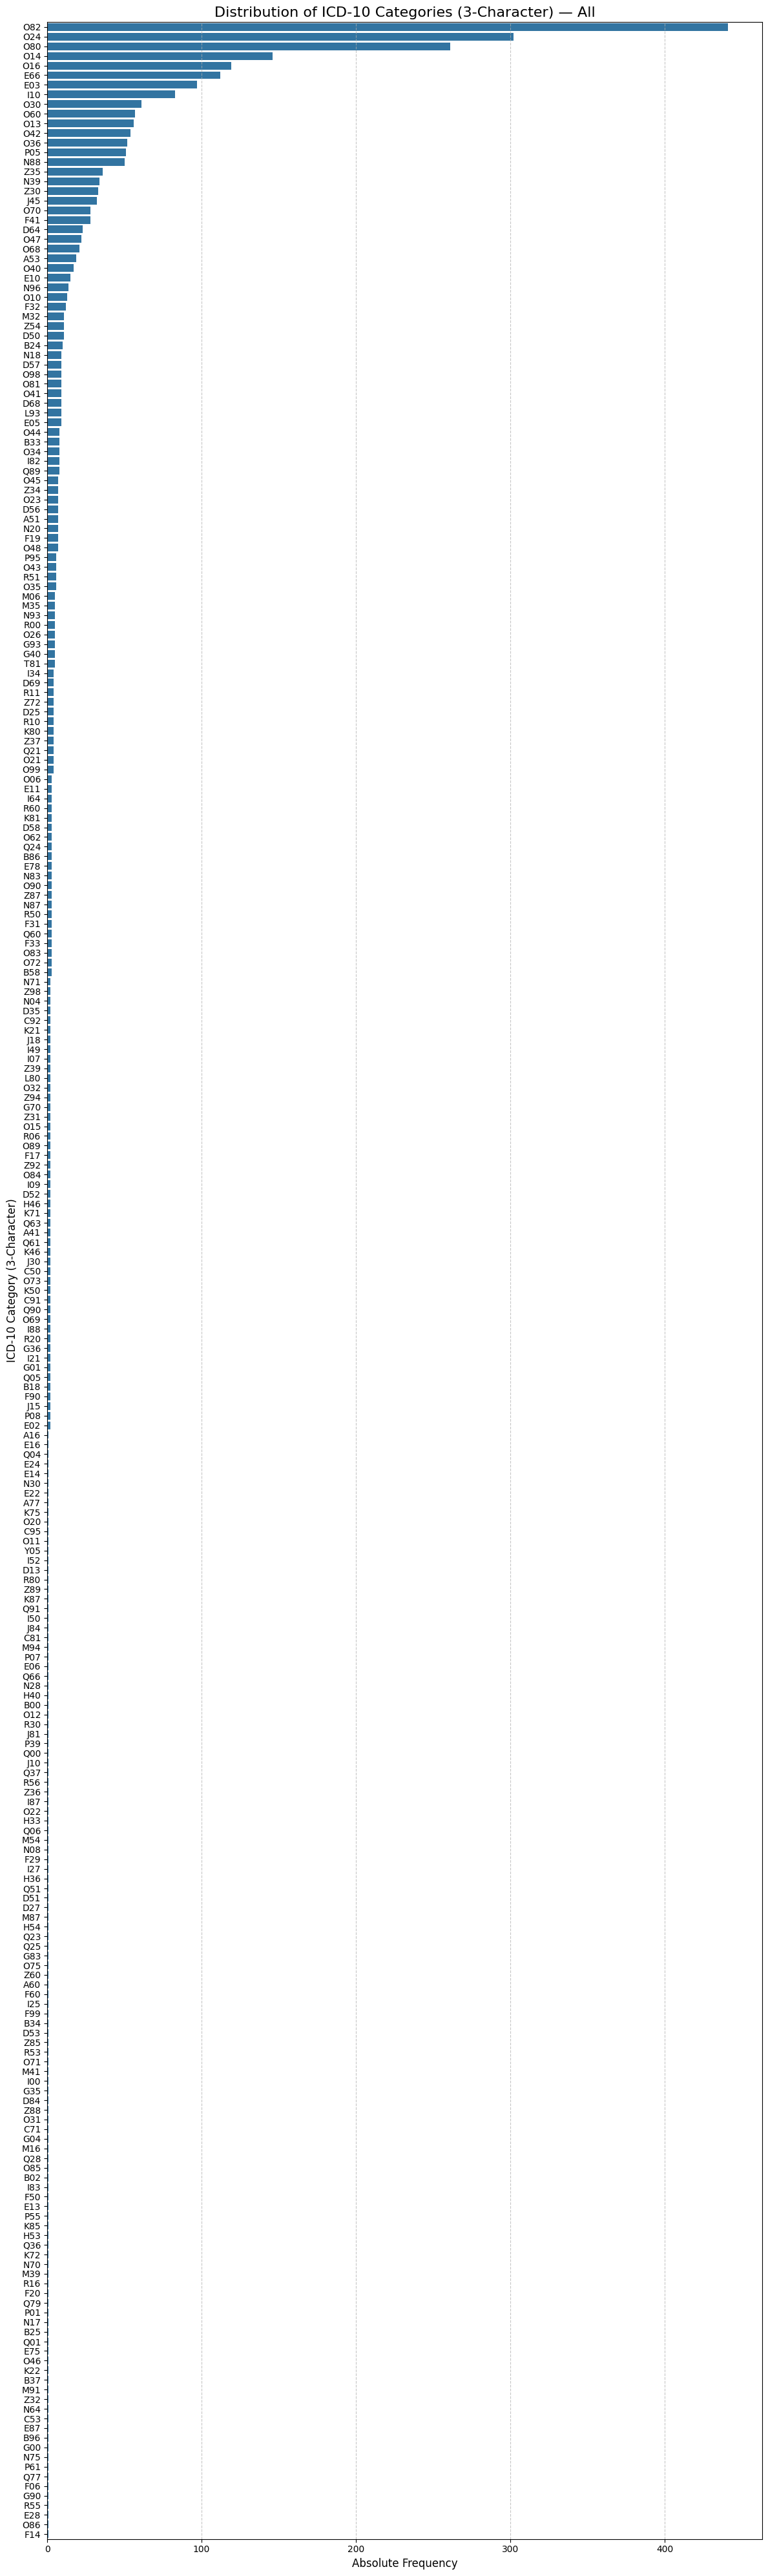

In [ ]:
# === Gráfico com TODAS as categorias 3-char (usando freq_3ch já calculado) ===
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Monta DataFrame com todas as categorias, ordenado por frequência
all3_df = (
    freq_3ch.rename_axis("Categoria_3ch")
            .reset_index(name="Frequência")
            .sort_values("Frequência", ascending=False)
)

# (Opcional) Se quiser filtrar por suporte mínimo, descomente a linha abaixo:
# MIN_SUPORTE = 1  # ex.: 5 para mostrar apenas categorias com >=5 ocorrências
# all3_df = all3_df[all3_df["Frequência"] >= MIN_SUPORTE]

# Altura dinâmica para caber todas as barras (com limite superior para evitar figuras gigantes)
n_cat = len(all3_df)
height_inches = min(max(6, n_cat * 0.22), 40)

plt.figure(figsize=(12, height_inches))

sns.barplot(
    data=all3_df,
    y="Categoria_3ch",
    x="Frequência",
    color="#1f77b4",   # tom único de azul (consistente com seu gráfico anterior)
    dodge=False
)

plt.title("Distribution of ICD-10 Categories (3-Character) — All", fontsize=16)
plt.xlabel("Absolute Frequency", fontsize=12)
plt.ylabel("ICD-10 Category (3-Character)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

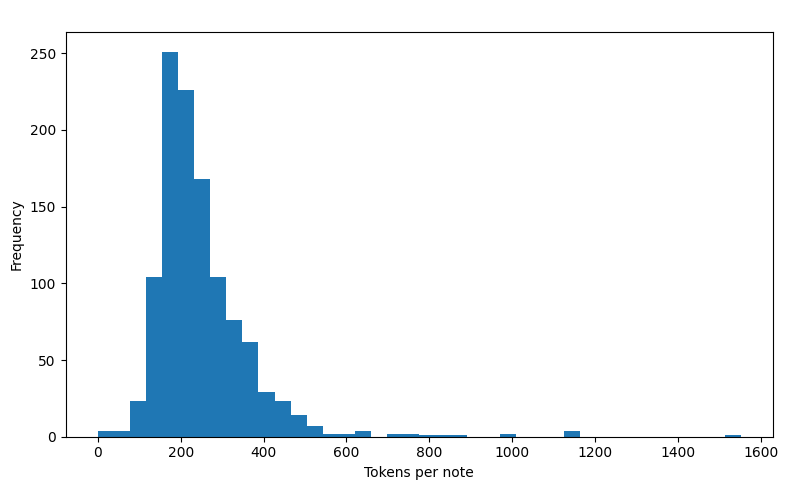

Saved to /content/corpus_stats/figures/FigS1_tokens_hist.(png|pdf)


In [ ]:
# === FIGURE S1 — Histogram of tokens per note (EN) ===
import os, re
import numpy as np
import matplotlib.pyplot as plt

# Escolhe a coluna de texto que existir
text_col = 'text' if 'text' in df_all.columns else 'texto'

def count_tokens(s):
    s = "" if s is None else str(s)
    return len(re.findall(r"\w+", s, flags=re.UNICODE))

if 'n_tokens' not in df_all.columns:
    df_all['n_tokens'] = df_all[text_col].apply(count_tokens)

# Pasta organizada do suplemento (opcional)
out_dir = "/content/corpus_stats/figures"
os.makedirs(out_dir, exist_ok=True)

plt.figure(figsize=(8,5))
plt.hist(df_all['n_tokens'], bins=40)
plt.xlabel("Tokens per note")
plt.ylabel("Frequency")
plt.title(" ")
plt.tight_layout()
plt.savefig(f"{out_dir}/FigS1_tokens_hist.png", dpi=300)
plt.savefig(f"{out_dir}/FigS1_tokens_hist.pdf", dpi=300)
plt.show()

print(f"Saved to {out_dir}/FigS1_tokens_hist.(png|pdf)")

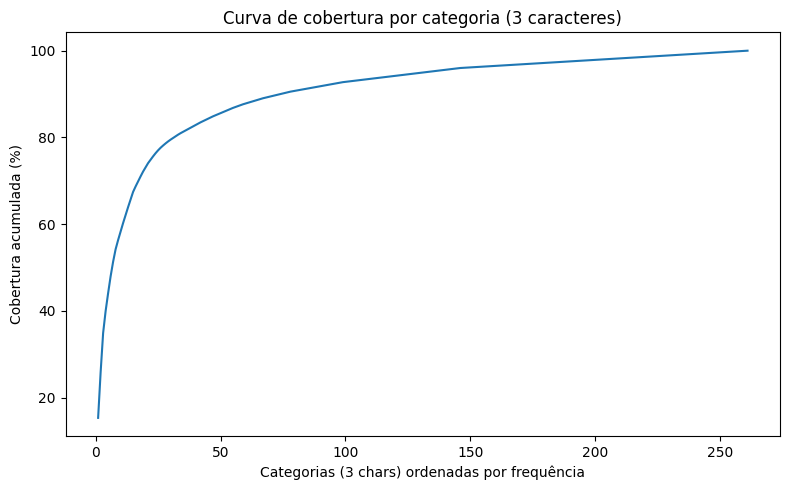

In [ ]:
# === FIGURA 2 — Curva Pareto (cobertura acumulada) por categoria 3 chars ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# conta frequências de categorias de 3 chars
all_3ch = [c for lst in df_all['codes_3char'] for c in lst]
freq_3ch = pd.Series(all_3ch).value_counts()

sorted_counts = freq_3ch.sort_values(ascending=False).values
cum = np.cumsum(sorted_counts) / sorted_counts.sum() * 100.0
x = np.arange(1, len(cum) + 1)

plt.figure(figsize=(8,5))
plt.plot(x, cum)
plt.xlabel("Categorias (3 chars) ordenadas por frequência")
plt.ylabel("Cobertura acumulada (%)")
plt.title("Curva de cobertura por categoria (3 caracteres)")
plt.tight_layout()
plt.savefig("/content/fig_pareto_3chars.png", dpi=300)
plt.savefig("/content/fig_pareto_3chars.pdf", dpi=300)
plt.show()




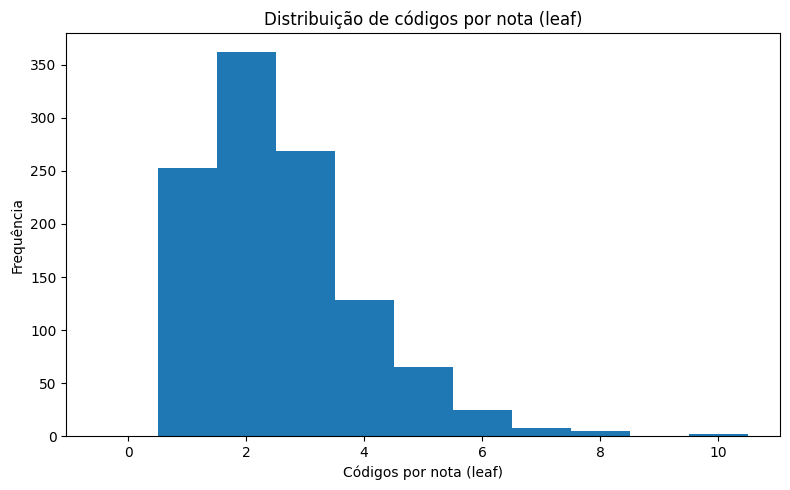

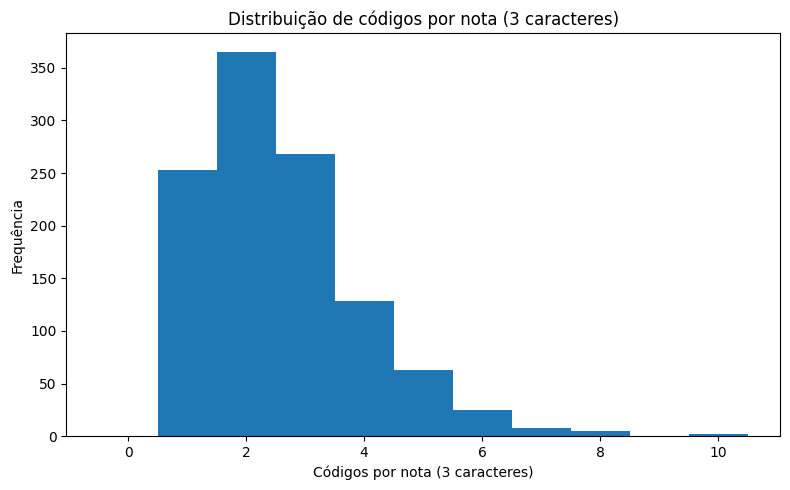

In [ ]:
# FIGURAS: histogramas de códigos por nota (leaf e 3 chars)
import matplotlib.pyplot as plt
import numpy as np
import re

# Garante colunas de contagem
if 'n_codes_leaf' not in df_all.columns:
    df_all['n_codes_leaf'] = df_all['codes_list'].str.len()
if 'n_codes_3ch' not in df_all.columns:
    df_all['n_codes_3ch'] = df_all['codes_3char'].str.len()

# Leaf
vals_leaf = df_all['n_codes_leaf'].to_numpy()
bins_leaf = np.arange(0, vals_leaf.max() + 2)  # inteiros alinhados
plt.figure(figsize=(8,5))
plt.hist(vals_leaf, bins=bins_leaf, align="left")
plt.xlabel("Códigos por nota (leaf)")
plt.ylabel("Frequência")
plt.title("Distribuição de códigos por nota (leaf)")
plt.tight_layout()
plt.savefig("/content/fig_hist_codigos_leaf.png", dpi=300)
plt.savefig("/content/fig_hist_codigos_leaf.pdf", dpi=300)
plt.show()

# 3 chars
vals_3ch = df_all['n_codes_3ch'].to_numpy()
bins_3ch = np.arange(0, vals_3ch.max() + 2)
plt.figure(figsize=(8,5))
plt.hist(vals_3ch, bins=bins_3ch, align="left")
plt.xlabel("Códigos por nota (3 caracteres)")
plt.ylabel("Frequência")
plt.title("Distribuição de códigos por nota (3 caracteres)")
plt.tight_layout()
plt.savefig("/content/fig_hist_codigos_3chars.png", dpi=300)
plt.savefig("/content/fig_hist_codigos_3chars.pdf", dpi=300)
plt.show()


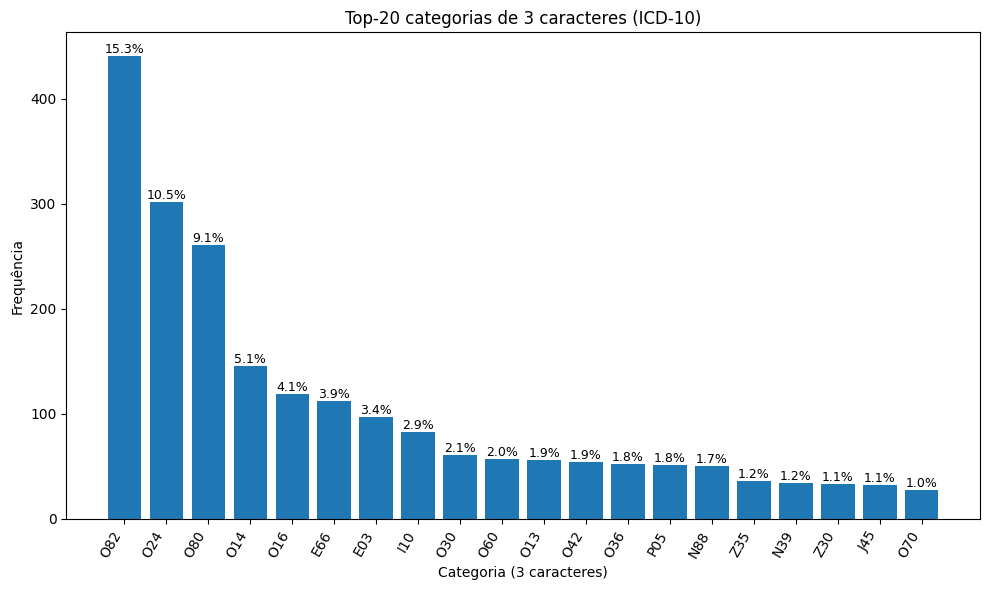

In [ ]:
# FIGURA: barras Top-20 categorias (3 chars) com rótulos em %
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Frequência por categoria 3 chars
all_3ch = [c for lst in df_all['codes_3char'] for c in lst]
freq_3ch = pd.Series(all_3ch).value_counts()
total = int(freq_3ch.sum())

top20 = (freq_3ch.head(20)
         .rename_axis("Categoria_3ch")
         .reset_index(name="Frequência"))
top20["Perc"] = (top20["Frequência"] / total * 100)

plt.figure(figsize=(10,6))
x = np.arange(len(top20))
plt.bar(x, top20["Frequência"])
plt.xticks(x, top20["Categoria_3ch"], rotation=60, ha="right")
plt.xlabel("Categoria (3 caracteres)")
plt.ylabel("Frequência")
plt.title("Top-20 categorias de 3 caracteres (ICD-10)")

# Rótulos de % no topo das barras
for i, (freq, p) in enumerate(zip(top20["Frequência"], top20["Perc"])):
    plt.text(i, freq, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("/content/fig_bar_top20_3chars.png", dpi=300)
plt.savefig("/content/fig_bar_top20_3chars.pdf", dpi=300)
plt.show()

80 códigos leaf cobrem 80% das ocorrências; 187 cobrem 90%.


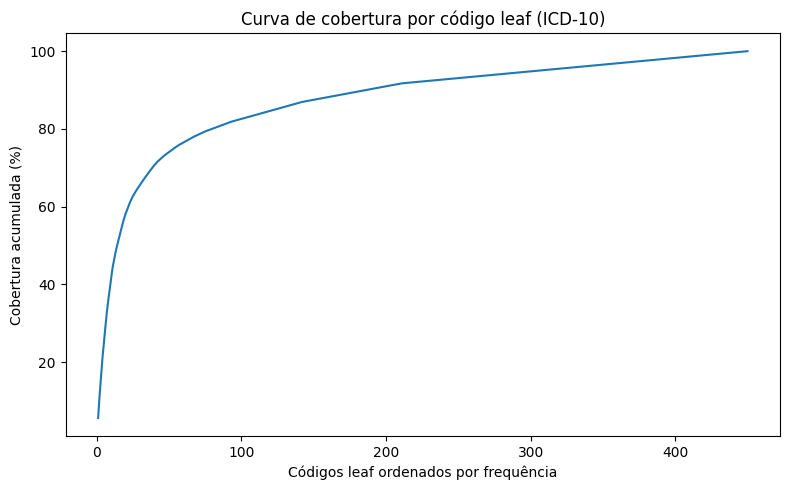

Salvo em /content/fig_pareto_leaf.png e .pdf


In [ ]:
# FIGURA — Curva Pareto para códigos leaf (ex.: O24.4)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Frequência por código leaf
all_leaf = [c for lst in df_all['codes_list'] for c in lst]
freq_leaf = pd.Series(all_leaf).value_counts()

sorted_counts = freq_leaf.sort_values(ascending=False).values
cum = np.cumsum(sorted_counts) / sorted_counts.sum() * 100.0
x = np.arange(1, len(cum) + 1)

# Pontos de corte (80% e 90%)
k80 = int(np.searchsorted(cum, 80, side="left") + 1)
k90 = int(np.searchsorted(cum, 90, side="left") + 1)
print(f"{k80} códigos leaf cobrem 80% das ocorrências; {k90} cobrem 90%.")

plt.figure(figsize=(8,5))
plt.plot(x, cum)
plt.xlabel("Códigos leaf ordenados por frequência")
plt.ylabel("Cobertura acumulada (%)")
plt.title("Curva de cobertura por código leaf (ICD-10)")
plt.tight_layout()
plt.savefig("/content/fig_pareto_leaf.png", dpi=300)
plt.savefig("/content/fig_pareto_leaf.pdf", dpi=300)
plt.show()

print("Salvo em /content/fig_pareto_leaf.png e .pdf")

In [ ]:
# Tabela Top-20 códigos leaf (ex.: O24.4) com percentuais
import pandas as pd

# parte do df_all que você já tem (com 'codes_list')
all_leaf = [c for lst in df_all['codes_list'] for c in lst]
freq_leaf = pd.Series(all_leaf).value_counts()
total_leaf = int(freq_leaf.sum())

top20_leaf = (freq_leaf.head(20)
              .rename_axis("Codigo_leaf")
              .reset_index(name="Frequencia"))
top20_leaf["% do total"] = (top20_leaf["Frequencia"]/total_leaf*100).round(2)

print(top20_leaf)

# salvar para suplemento
top20_leaf.to_csv("/content/Top20_codigos_leaf.csv", index=False)
with open("/content/Top20_codigos_leaf.tex","w",encoding="utf-8") as f:
    f.write(top20_leaf.to_latex(index=False, escape=False))

   Codigo_leaf  Frequencia  % do total
0        O82.0         164        5.68
1        O24.9         164        5.68
2          O82         145        5.02
3        O80.0         135        4.68
4          O16         119        4.12
5        E66.9         110        3.81
6        O14.9         109        3.78
7        O82.9          91        3.15
8          I10          83        2.87
9        E03.9          80        2.77
10         O80          79        2.74
11         O13          56        1.94
12         O24          56        1.94
13       N88.3          48        1.66
14       P05.9          43        1.49
15       O42.9          43        1.49
16         O60          42        1.45
17       O80.9          41        1.42
18       O30.0          38        1.32
19       O24.0          33        1.14


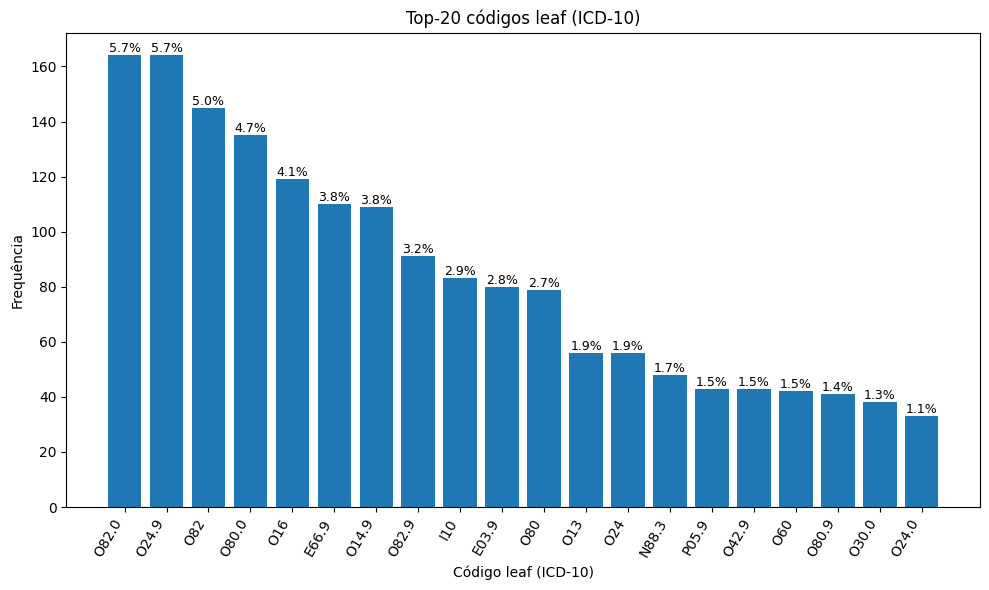

In [ ]:
# FIGURA — Barras Top-20 códigos leaf (com % no rótulo)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Se ainda não tiver as frequências calculadas:
all_leaf = [c for lst in df_all['codes_list'] for c in lst]
freq_leaf = pd.Series(all_leaf).value_counts()
total_leaf = int(freq_leaf.sum())

top20_leaf = (freq_leaf.head(20)
              .rename_axis("Codigo_leaf")
              .reset_index(name="Frequencia"))
top20_leaf["Perc"] = (top20_leaf["Frequencia"] / total_leaf * 100)

plt.figure(figsize=(10,6))
x = np.arange(len(top20_leaf))
plt.bar(x, top20_leaf["Frequencia"])
plt.xticks(x, top20_leaf["Codigo_leaf"], rotation=60, ha="right")
plt.xlabel("Código leaf (ICD-10)")
plt.ylabel("Frequência")
plt.title("Top-20 códigos leaf (ICD-10)")

# rótulos percentuais no topo de cada barra
for i, (freq, p) in enumerate(zip(top20_leaf["Frequencia"], top20_leaf["Perc"])):
    plt.text(i, freq, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("/content/fig_bar_top20_leaf.png", dpi=300)
plt.savefig("/content/fig_bar_top20_leaf.pdf", dpi=300)
plt.show()


In [ ]:
# ===========================
# Corpus statistics & figures (English) — ICD-10 obstetric notes
# ===========================

import os, re, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# ---------- Paths ----------
BASE_DIR = "/content/corpus_stats"
FIG_DIR  = os.path.join(BASE_DIR, "figures")
TAB_DIR  = os.path.join(BASE_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# ---------- Load ----------
# Ajuste se o caminho for diferente:
path = "/content/drive/MyDrive/Doutorado - Ricardo- Após a Qualificação/Paper: EVALUATING LARGE LANGUAGE MODELS FOR AUTOMATED ICD-10 CODING OF OBSTETRIC CLINICAL NOTES IN PORTUGUESE: A COMPARATIVE STUDY/Data/Data_LLMs_and_Gold_and_EHRs.pkl"
df = pd.read_pickle(path)

COL_TEXTO = '25. Evolução Alta'
COL_CIDS  = '21. CID de Alta'

# ---------- Normalization (on-the-fly) with logging ----------
fix_counts = defaultdict(int)
invalid_counter = Counter()

def normalize_token(t: str) -> str | None:
    """Return normalized ICD-10 code or None if invalid; logs fixes."""
    if t is None:
        return None
    raw = str(t)
    # spaces
    if re.search(r"\s", raw): fix_counts["spaces_removed"] += 1
    s = re.sub(r"\s+", "", raw).upper()
    if s != raw.upper(): fix_counts["uppercased"] += 1

    # comma decimal -> dot (O24,4 -> O24.4) only if pattern A00,0...
    if ',' in s and re.match(r'^[A-Z]\d{2},\d+$', s):
        s = s.replace(',', '.'); fix_counts["comma_to_dot"] += 1

    # hyphen -> dot (O24-4 -> O24.4)
    if '-' in s:
        s = s.replace('-', '.'); fix_counts["hyphen_to_dot"] += 1

    # leading zero -> letter O (047 -> O47)
    if re.match(r'^0(?=\d{2}(?:\.\d+)?)', s):
        s = re.sub(r'^0','O', s); fix_counts["leading0_to_O"] += 1

    # final validation (allow A–Z + 2 digits + optional .subdigits)
    if re.match(r'^[A-Z]\d{2}(\.\d+)?$', s):
        return s
    invalid_counter[s] += 1
    return None

def to_code_list(x):
    """Accept list/array or string; split on ';' and '/', not on ','."""
    if isinstance(x, (list, np.ndarray)):
        items = list(x)
    else:
        s = "" if pd.isna(x) else str(x)
        s = s.replace('/', ';')
        items = [t.strip() for t in s.split(';') if t.strip()]
    out = []
    for t in items:
        z = normalize_token(t)
        if z is not None:
            out.append(z)
    return sorted(set(out))

# ---------- Build df_all (keep n=1117 with >=1 valid code; tokens=0 if empty text) ----------
df_all = df[[COL_TEXTO, COL_CIDS]].copy()
df_all.columns = ["text", "codes_raw"]
df_all["codes_list"]  = df_all["codes_raw"].apply(to_code_list)
df_all["codes_3char"] = df_all["codes_list"].apply(lambda lst: sorted({c.split(".")[0] for c in lst}))
df_all = df_all[df_all["codes_list"].str.len().gt(0)].copy()  # expect 1117

# Tokens (0 for empty text)
def count_tokens(s):
    s = "" if s is None else str(s)
    return len(re.findall(r"\w+", s, flags=re.UNICODE))
df_all["n_tokens"] = df_all["text"].apply(count_tokens)

# Per-note counts
df_all["n_codes_leaf"] = df_all["codes_list"].str.len()
df_all["n_codes_3ch"]  = df_all["codes_3char"].str.len()

# Aggregates
all_leaf = [c for lst in df_all["codes_list"] for c in lst]
all_3ch  = [c for lst in df_all["codes_3char"] for c in lst]
freq_3ch = pd.Series(all_3ch).value_counts()
freq_leaf = pd.Series(all_leaf).value_counts()

def summarize_series(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return dict(mean=np.nan,std=np.nan,median=np.nan,q1=np.nan,q3=np.nan,iqr=np.nan)
    q1,q3 = np.percentile(s, [25,75])
    return dict(
        mean=float(np.mean(s)),
        std=float(np.std(s, ddof=1)) if len(s)>1 else 0.0,
        median=float(np.median(s)),
        q1=float(q1), q3=float(q3), iqr=float(q3-q1)
    )

tok  = summarize_series(df_all["n_tokens"])
leaf = summarize_series(df_all["n_codes_leaf"])
ch3  = summarize_series(df_all["n_codes_3ch"])

total_labels_3ch = int(freq_3ch.sum())
cov_top10 = (freq_3ch.head(10).sum()/total_labels_3ch) if total_labels_3ch else 0.0
cov_top20 = (freq_3ch.head(20).sum()/total_labels_3ch) if total_labels_3ch else 0.0
pct_lt5   = (freq_3ch[freq_3ch<5].shape[0]/freq_3ch.shape[0]*100) if freq_3ch.shape[0] else 0.0
pct_lt10  = (freq_3ch[freq_3ch<10].shape[0]/freq_3ch.shape[0]*100) if freq_3ch.shape[0] else 0.0

# ---------- Table S1 (CSV + LaTeX) ----------
S1 = pd.DataFrame([
    ("Notes (n)", df_all.shape[0]),
    ("Tokens per note — mean ± SD", f"{tok['mean']:.1f} ± {tok['std']:.1f}"),
    ("Tokens per note — median [IQR]", f"{tok['median']:.0f} [{tok['q1']:.0f}–{tok['q3']:.0f}]"),
    ("Codes per note (leaf) — mean ± SD", f"{leaf['mean']:.2f} ± {leaf['std']:.2f}"),
    ("Codes per note (leaf) — median [IQR]", f"{leaf['median']:.0f} [{leaf['q1']:.0f}–{leaf['q3']:.0f}]"),
    ("Codes per note (3-char) — mean ± SD", f"{ch3['mean']:.2f} ± {ch3['std']:.2f}"),
    ("Codes per note (3-char) — median [IQR]", f"{ch3['median']:.0f} [{ch3['q1']:.0f}–{ch3['q3']:.0f}]"),
    ("Distinct 3-char categories", freq_3ch.shape[0]),
    ("Distinct leaf codes", freq_leaf.shape[0]),
    ("Top-10 3-char coverage", f"{cov_top10*100:.2f}%"),
    ("Top-20 3-char coverage", f"{cov_top20*100:.2f}%"),
    ("% of 3-char categories with support <5",  f"{pct_lt5:.2f}%"),
    ("% of 3-char categories with support <10", f"{pct_lt10:.2f}%"),
], columns=["Metric","Value"])

S1.to_csv(os.path.join(TAB_DIR, "Table_S1_corpus_summary.csv"), index=False)
with open(os.path.join(TAB_DIR, "Table_S1_corpus_summary.tex"), "w", encoding="utf-8") as f:
    f.write(S1.to_latex(index=False, escape=False))

# ---------- Top-20 tables (3-char and leaf) ----------
top20_3ch = (freq_3ch.head(20).rename_axis("3-char category").reset_index(name="Frequency"))
top20_3ch["% of total"] = (top20_3ch["Frequency"]/total_labels_3ch*100).round(2)
top20_3ch.to_csv(os.path.join(TAB_DIR, "Top20_3char.csv"), index=False)
with open(os.path.join(TAB_DIR, "Top20_3char.tex"), "w", encoding="utf-8") as f:
    f.write(top20_3ch.to_latex(index=False, escape=False))

total_leaf = int(freq_leaf.sum())
top20_leaf = (freq_leaf.head(20).rename_axis("Leaf code").reset_index(name="Frequency"))
top20_leaf["% of total"] = (top20_leaf["Frequency"]/total_leaf*100).round(2)
top20_leaf.to_csv(os.path.join(TAB_DIR, "Top20_leaf.csv"), index=False)
with open(os.path.join(TAB_DIR, "Top20_leaf.tex"), "w", encoding="utf-8") as f:
    f.write(top20_leaf.to_latex(index=False, escape=False))

# ---------- Normalization log (for Supplement) ----------
norm_log = {
    "notes_total": int(df_all.shape[0]),
    "notes_tokens_equal_0": int((df_all["n_tokens"]==0).sum()),
    "fix_counts": dict(fix_counts),
    "top_invalid_after_normalization": invalid_counter.most_common(20),
}
with open(os.path.join(TAB_DIR, "Normalization_log.json"), "w", encoding="utf-8") as f:
    json.dump(norm_log, f, ensure_ascii=False, indent=2)

# ---------- Figures (PNG + PDF, English) ----------
plt.figure(figsize=(8,5))
plt.hist(df_all["n_tokens"], bins=40)
plt.xlabel("Tokens per note")
plt.ylabel("Frequency")
plt.title("Distribution of note lengths")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "FigS1_tokens_hist.png"), dpi=300)
plt.savefig(os.path.join(FIG_DIR, "FigS1_tokens_hist.pdf"), dpi=300)
plt.close()

sorted_counts = freq_3ch.sort_values(ascending=False).values
cum = np.cumsum(sorted_counts)/sorted_counts.sum()*100.0
x = np.arange(1, len(cum)+1)
plt.figure(figsize=(8,5))
plt.plot(x, cum)
plt.xlabel("3-char categories (sorted by frequency)")
plt.ylabel("Cumulative coverage (%)")
plt.title("Cumulative coverage by 3-char categories")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "FigS2_pareto_3char.png"), dpi=300)
plt.savefig(os.path.join(FIG_DIR, "FigS2_pareto_3char.pdf"), dpi=300)
plt.close()

vals_leaf = df_all["n_codes_leaf"].to_numpy()
bins_leaf = np.arange(0, vals_leaf.max()+2)
plt.figure(figsize=(8,5))
plt.hist(vals_leaf, bins=bins_leaf, align="left")
plt.xlabel("Codes per note (leaf)")
plt.ylabel("Frequency")
plt.title("Distribution of codes per note (leaf)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "FigS3_codes_per_note_leaf.png"), dpi=300)
plt.savefig(os.path.join(FIG_DIR, "FigS3_codes_per_note_leaf.pdf"), dpi=300)
plt.close()

vals_3ch = df_all["n_codes_3ch"].to_numpy()
bins_3ch = np.arange(0, vals_3ch.max()+2)
plt.figure(figsize=(8,5))
plt.hist(vals_3ch, bins=bins_3ch, align="left")
plt.xlabel("Codes per note (3-char)")
plt.ylabel("Frequency")
plt.title("Distribution of codes per note (3-char)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "FigS4_codes_per_note_3char.png"), dpi=300)
plt.savefig(os.path.join(FIG_DIR, "FigS4_codes_per_note_3char.pdf"), dpi=300)
plt.close()

# Bar — Top-20 3-char with % labels
plt.figure(figsize=(10,6))
xpos = np.arange(len(top20_3ch))
plt.bar(xpos, top20_3ch["Frequency"])
plt.xticks(xpos, top20_3ch["3-char category"], rotation=60, ha="right")
plt.xlabel("3-char category")
plt.ylabel("Frequency")
plt.title("Top-20 3-char categories")
for i, (freq, p) in enumerate(zip(top20_3ch["Frequency"], top20_3ch["% of total"])):
    plt.text(i, freq, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "FigS5_top20_3char.png"), dpi=300)
plt.savefig(os.path.join(FIG_DIR, "FigS5_top20_3char.pdf"), dpi=300)
plt.close()

# Pareto — leaf
sorted_counts_leaf = freq_leaf.sort_values(ascending=False).values
cum_leaf = np.cumsum(sorted_counts_leaf)/sorted_counts_leaf.sum()*100.0
x2 = np.arange(1, len(cum_leaf)+1)
k80 = int(np.searchsorted(cum_leaf, 80, side="left")+1)
k90 = int(np.searchsorted(cum_leaf, 90, side="left")+1)
plt.figure(figsize=(8,5))
plt.plot(x2, cum_leaf)
plt.xlabel("Leaf codes (sorted by frequency)")
plt.ylabel("Cumulative coverage (%)")
plt.title(f"Cumulative coverage by leaf codes (80% in {k80}, 90% in {k90})")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "FigS6_pareto_leaf.png"), dpi=300)
plt.savefig(os.path.join(FIG_DIR, "FigS6_pareto_leaf.pdf"), dpi=300)
plt.close()

# Bar — Top-20 leaf with % labels
plt.figure(figsize=(10,6))
xpos2 = np.arange(len(top20_leaf))
plt.bar(xpos2, top20_leaf["Frequency"])
plt.xticks(xpos2, top20_leaf["Leaf code"], rotation=60, ha="right")
plt.xlabel("Leaf code")
plt.ylabel("Frequency")
plt.title("Top-20 leaf codes")
for i, (freq, p) in enumerate(zip(top20_leaf["Frequency"], top20_leaf["% of total"])):
    plt.text(i, freq, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "FigS7_top20_leaf.png"), dpi=300)
plt.savefig(os.path.join(FIG_DIR, "FigS7_top20_leaf.pdf"), dpi=300)
plt.close()

print("Done.")
print(f"Tables -> {TAB_DIR}\nFigures -> {FIG_DIR}")
print("Normalization log:", json.dumps(norm_log, indent=2, ensure_ascii=False)[:600], "...")


Done.
Tables -> /content/corpus_stats/tables
Figures -> /content/corpus_stats/figures
Normalization log: {
  "notes_total": 1117,
  "notes_tokens_equal_0": 2,
  "fix_counts": {
    "leading0_to_O": 7,
    "comma_to_dot": 1
  },
  "top_invalid_after_normalization": [
    [
      "DE",
      2
    ],
    [
      "SUPERVISAO",
      1
    ],
    [
      "GRAVIDEZ",
      1
    ],
    [
      "ALTO",
      1
    ],
    [
      "RISCO",
      1
    ],
    [
      "O82.0'",
      1
    ],
    [
      "O82.",
      1
    ],
    [
      "HIPOTIREOIDISMO",
      1
    ],
    [
      "NÃO",
      1
    ],
    [
      "ESPECIFICADO",
      1
    ],
    [
      "HIPERTENSAO",
      1
    ],
    [
      "ESSE ...
